# Part 2 - the MNIST dataset

For ease of use, the MINST handwritten digits dataset comes packaged up with TensorFlow, so let's load it and have a look around.

In [113]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import math
import time
from tensorflow.python.framework import ops

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

mnist = tf.keras.datasets.mnist


In [60]:
(x_train, y_train),(x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# reshape y to arrays of shape (m,1)
y_train, y_test = y_train.reshape(y_train.shape[0], 1), y_test.reshape(y_test.shape[0], 1)

print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_test.shape)
print ("x_test shape:", x_train.shape)
print ("y_test shape:", y_test.shape)

x_train shape: (60000, 28, 28)
y_train shape: (10000, 1)
x_test shape: (60000, 28, 28)
y_test shape: (10000, 1)


Now let's visualise some examples of the training set with their labels

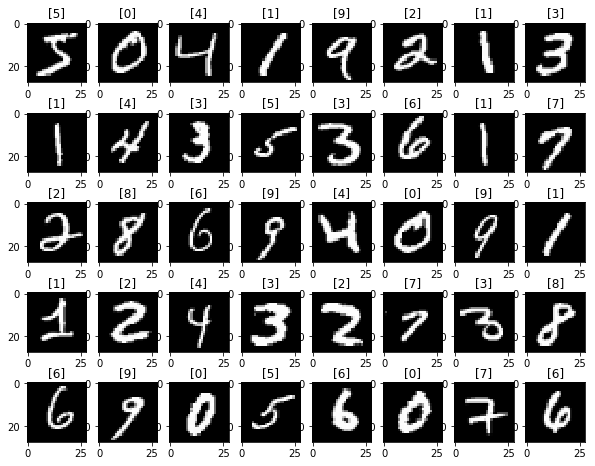

In [130]:
display_examples_n = 40
rows = 5
cols = 8
fig, axarr = plt.subplots(rows, cols)

for r in range (0, rows):
    for c in range (0, cols):
        # axarr[r][c].title.set_text('x_train[' + str((r*cols)+c) +']: ' + str(y_train[(r*cols)+c]))
        axarr[r][c].title.set_text(str(y_train[(r*cols)+c]))
        axarr[r][c].imshow(x_train[(r*cols)+c])

Once again, let's look at the number of items in each class:

In [61]:
np.unique (y_train, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]))

It would probably be better if the training set had equal numbers of items in each class, and we wrote code that does this in carving up the set into a train and dev set. No need to split off a test set, as we already have one.

In [63]:
np.unique (y_test, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([ 980, 1135, 1032, 1010,  982,  892,  958, 1028,  974, 1009]))

In [92]:
def get_train_dev_sets (X, Y, train_set_proportion = 0.9):
    """
    Takes set of features (X) as (n,m) matrix and labels (Y) as (1,m) matrix and splits them into train and dev 
    sets only, of specified proportions. It's assumed that a test set isn't needed.
    Train set will have same number of examples of each class
    
    returns: train_set_X, train_set_Y, dev_set_X, dev_set_Y
    """
    
    size_classes = np.unique(Y, return_counts = True)[1] # get an array of all class sizes

    # our training set contains train_set_proportion * smallest class size of each class
    size_smallest_class = min (np.unique (Y, return_counts = True)[1]) 
    size_train_set_class = int (train_set_proportion * size_smallest_class)
    print ("size_train_set_class:", size_train_set_class)
    # print ("size_dev_set_class:", size_dev_set_class)
    
    
    num_classes = np.shape(np.unique(Y))[0]

    size_classes_cum = np.empty ((0))
    for i in range (0, num_classes): # get an array of cumulative indices, starting with 0, for where each class starts
        size_classes_cum = np.append (size_classes_cum, int (sum(size_classes[0:i])))
    # add on final size of the data set +1 so we can iterate i+1 over num_classes to get end indices
    size_classes_cum = np.append (size_classes_cum, int(Y.shape[1]))
    
    
    #print ("num classes: ", num_classes)
    #print ("size_classes_cum: ", size_classes_cum)
    #print ("dtype size_classes_cum:", type (size_classes_cum))
    
    sorted_indices = np.argsort (Y[0,:]) # get the list of indices that will sort Y by class
    # print ("sorted_indices.shape:", sorted_indices.shape)
    X_sorted = X[:, sorted_indices]
    Y_sorted = Y[:, sorted_indices] 
    

    
    # initialise sets
    train_set_X = np.empty ((X.shape[0], 0))
    train_set_Y = np.empty ((1, 0))
    dev_set_X = np.empty ((X.shape[0], 0))
    dev_set_Y = np.empty ((1, 0))
    
    # print ("train_set_X.shape before append:", train_set_X.shape)
    # print ("train_set_Y.shape before append:", train_set_Y.shape)
    
    for i in range (0, num_classes):
        # print ("size_classes_cum[i]:", size_classes_cum[i])
        # print ("size_classes_cum[i]+size_train_set_class:", size_classes_cum[i]+size_train_set_class)
        X_this_class = X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)]
        # print ("X_this_class shape:", X_this_class.shape)
        train_set_X = np.append (train_set_X, X_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)
        train_set_Y = np.append (train_set_Y, Y_sorted[:, int (size_classes_cum[i]):int (size_classes_cum[i]+size_train_set_class)], axis=1)
        
        dev_set_X = np.append (dev_set_X, X_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], axis=1)
        dev_set_Y = np.append (dev_set_Y, Y_sorted[:, int (size_classes_cum[i]+size_train_set_class):int(size_classes_cum[i+1])], axis=1)

       
    # Finally, apply the same shuffle to X and Y sets
    train_shuffled_indices = np.arange (train_set_X.shape[1])
    dev_shuffled_indices = np.arange (dev_set_X.shape[1])

    np.random.shuffle (train_shuffled_indices)
    np.random.shuffle (dev_shuffled_indices)

    train_set_X = train_set_X[:,train_shuffled_indices]
    train_set_Y = train_set_Y[:,train_shuffled_indices].astype (np.int16)    
    dev_set_X = dev_set_X[:,dev_shuffled_indices]
    dev_set_Y = dev_set_Y[:,dev_shuffled_indices].astype (np.int16)    
    
    return train_set_X, train_set_Y, dev_set_X, dev_set_Y

In [93]:
print ("x_train shape:", x_train.shape)
print ("y_train shape:", y_train.shape)
print ("x_test shape:", x_test.shape)
print ("y_test shape:", y_test.shape)


x_train_unrow = x_train.reshape(x_train.shape[0], x_train.shape[1] * x_train.shape[2])
x_test_unrow = x_test.reshape(x_test.shape[0], x_test.shape[1] * x_test.shape[2])

print ("x_train_unrow shape:", x_train_unrow.shape)
print ("x_test_unrow shape:", x_test_unrow.shape)

x_train_trans = x_train_unrow.T
x_test_trans = x_test_unrow.T
y_train_trans = y_train.T
y_test_trans = y_test.T
print ("x_train_trans shape:", x_train_trans.shape)
print ("y_train_trans shape:", y_train_trans.shape)
print ("x_test_trans shape:", x_test_trans.shape)
print ("y_test_trans shape:", y_test_trans.shape)

x_train shape: (60000, 28, 28)
y_train shape: (60000, 1)
x_test shape: (10000, 28, 28)
y_test shape: (10000, 1)
x_train_unrow shape: (60000, 784)
x_test_unrow shape: (10000, 784)
x_train_trans shape: (784, 60000)
y_train_trans shape: (1, 60000)
x_test_trans shape: (784, 10000)
y_test_trans shape: (1, 10000)


In [117]:
tic=time.time()
train_set_X, train_set_Y, dev_set_X, dev_set_Y = get_train_dev_sets (x_train_trans, y_train_trans)

#train_set_X = train_set_X.T
#train_set_Y = train_set_Y.T
#dev_set_X = dev_set_X.T
#dev_set_Y = dev_set_Y.T

print ("train_set_X.shape: ", train_set_X.shape)
print ("train_set_Y.shape: ", train_set_Y.shape)
print ("dev_set_X.shape:", dev_set_X.shape)
print ("dev_set_Y.shape:", dev_set_Y.shape)
timer = time.time() - tic
print ("execution time: %f s" % timer)

size_train_set_class: 4878
train_set_X.shape:  (784, 48780)
train_set_Y.shape:  (1, 48780)
dev_set_X.shape: (784, 11220)
dev_set_Y.shape: (1, 11220)
execution time: 2.342122 s


In [96]:
np.unique (train_set_Y, return_counts = True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int16),
 array([4878, 4878, 4878, 4878, 4878, 4878, 4878, 4878, 4878, 4878]))

In [99]:
def convert_to_one_hot(Y, C): 
    """
    Converts a vector Y of multiclass-responses coded as integer values (0, 1, 2, etc.... C-1) 
    to a (C,m) dimensional matrix where each row represents a response, and values are either 0 or 1
    """
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [100]:
print (train_set_Y[:,0:10])

train_set_Y_one_hot = convert_to_one_hot (train_set_Y,  10)
dev_set_Y_one_hot = convert_to_one_hot (dev_set_Y,  10)
print ("...converts to:")
print (train_set_Y_one_hot[:, 0:10])

[[0 6 6 3 1 2 1 0 9 8]]
...converts to:
[[ 1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]]


In [101]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

# Time to make and train the model!

In [102]:
def create_placeholders(n_x, n_y):
    """
    Creates placeholders for input feature vector (X) and labels vector (Y) 
    
    Arguments:
    n_x -- scalar, size of the input feature vector 
    n_y -- scalar, number of classes 
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    """

    X = tf.placeholder(dtype="float", shape=(n_x, None), name="X")
    Y = tf.placeholder(dtype="float", shape=(n_y, None), name="Y")
    
    return X, Y

In [103]:
X, Y = create_placeholders(784, 10)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(784, ?), dtype=float32)
Y = Tensor("Y:0", shape=(10, ?), dtype=float32)


In [104]:
def initialize_parameters_3layers(size_input, size_l1, size_l2, size_l3):
    """
    Initializes parameters for a 3 layer tensorflow neural network, where l1 is the first hidden layer 
    and l3 is the output layer.
    Uses Xavier initialization.
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable ("W1", [size_l1,size_input], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable ("b1", [size_l1,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable ("W2", [size_l2,size_l1], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable ("b2", [size_l2,1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable ("W3", [size_l3,size_l2], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable ("b3", [size_l3,1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [105]:
def forward_propagation_3layers(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3

In [106]:
def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)    
    
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
        
    return cost

The following generates a three-layer model, with layers l1 = 784, l2 = 400, l3 = 150, l4 = 10, with l1 through l3 using relu units, and l4 a softmax layer. The parameters are trained via backprop optimising to softmax cross-entropy loss. i.e. this is all very vanilla for a fully-connected network.

In [118]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    X, Y = create_placeholders (n_x, n_y)
    parameters = initialize_parameters_3layers(size_input = 784, size_l1 = 400, size_l2 = 150, size_l3 = 10)
    Z3 = forward_propagation_3layers (X, parameters)
    cost = compute_cost (Z3, Y)
    optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
    
    init = tf.global_variables_initializer()

    tic = time.time()
    
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                # the line that runs the optimizer
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 50 == 0:
                timer = time.time() - tic
                print ("Cost after epoch %i: %f, running for %f seconds" % (epoch, epoch_cost, timer))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")
        timer = time.time() - tic
        print ("Execution time %f" % timer)

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 2.312588, running for 5.534426
Cost after epoch 50: 1.307442, running for 279.469809
Cost after epoch 100: 0.604256, running for 552.639311
Cost after epoch 150: 0.251975, running for 826.481691
Cost after epoch 200: 0.118786, running for 1109.778823
Cost after epoch 250: 0.058459, running for 1418.036457
Cost after epoch 300: 0.048144, running for 1702.131089
Cost after epoch 350: 0.063080, running for 2023.059250
Cost after epoch 400: 0.038655, running for 2310.961584
Cost after epoch 450: 0.030095, running for 2655.753014


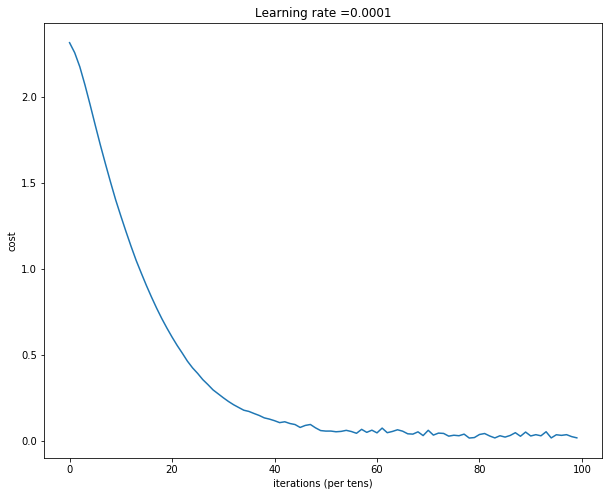

Parameters have been trained!
Execution time 2994.268142
Train Accuracy: 0.997663
Test Accuracy: 0.101337


In [119]:
parameters = model(train_set_X, train_set_Y_one_hot, dev_set_X, dev_set_Y_one_hot)

On my intel Core i5-3380M laptop the model takes about 40 minutes to train (for 500 epochs, on 48,780 training examples). The fact is, for the first layer alone, 784 x 784 units = 614,656 weight parameters. This is an illustration of why convolutional networks might be more efficient to train on image data - and 28x28 greyscale is *not* a big image.

However, the cost does approach floor after ~300 epochs, suggesting 500 epochs might not be excessively short.

Accuracy - the model performs *very* well on the training data set, achieving 99.7% accuracy. However, the model only scores 10% on the test data set (ie chance) suggesting it's over-fitted and not learned to generalise *at all*.  

Next steps - 
1. Code a cost/epoch graph which updates in real time as the model trains.
2. Multiple models trained in parallel, with both models cost on the same graph.
3. Ability to save/restore parameters. Once we've gone to the trouble of training the model (especially for more than 500 epochs), we don't necessarily want to do it again willy-nilly.
4. Ability to graph previous models cost/epoch training graph alongside a new model that's being trained, to see if it's better/worse than previous iterations. 

In [125]:
def predict(X, parameters):
    """
    Using the learned parameters, predicts a class for each example in X
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (n_x, m)
    
    Returns
    predictions -- vector of predictions of our model (softmax: probability/confidence of each class)
    """

    # Retrieve the parameters from the dictionary "parameters"     
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    x = tf.placeholder("float", [784, None])  # IMPORTANT Note we need to use None here as we don't know how many training
                                            # examples will be passed in via feed_dict

                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    # Computes probabilities using forward propagation, and classifies to 0/1 using 0.5 as the threshold.
  
    p = tf.argmax(Z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [128]:
def evaluate_predictions_byclass (X, Y, num_classes = 10):

    predict_set_X = X.astype(np.float32)
    # print ("predict_set_X:\n", predict_set_X)
    #predict_set_X = predict_set_X.reshape(2,1) 
    # predict_set_X.shape
    # type (predict_set_X[0,0]) # confirm type is float32

    prediction = predict (predict_set_X, parameters)
    # print ("The model predicted:", prediction)
    # print ("The correct labels are:\n", test_set_Y)
    
    evaluate_predictions = np.append(prediction.reshape(Y.shape), Y, axis=0)

    correct = (evaluate_predictions[0,:] == evaluate_predictions[1,:]) # get a vector of True/False values

    classes = np.arange(0, num_classes)

    correct_by_class = np.bincount(evaluate_predictions[0,:], weights=correct) # weight the bincount by True/False (ie only count correct responses)
    totals_by_class = np.bincount(evaluate_predictions[1,:])

    accuracy_by_class = np.divide (correct_by_class, totals_by_class)
    return accuracy_by_class


In [129]:
evaluate_predictions_byclass (dev_set_X, dev_set_Y)

array([ 0.09856459,  0.11266094,  0.12222222,  0.07581804,  0.09232365,
        0.10128913,  0.08942308,  0.12328767,  0.08530319,  0.13352007])